In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

In [38]:
data = pd.read_csv('./tmdb_movies_cleaned.csv')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9953 non-null   int64  
 1   title                       9953 non-null   object 
 2   runtime                     9953 non-null   int64  
 3   release_date                9953 non-null   object 
 4   budget                      9953 non-null   int64  
 5   revenue                     9953 non-null   int64  
 6   popularity                  9953 non-null   float64
 7   vote_average                9953 non-null   float64
 8   vote_count                  9953 non-null   int64  
 9   belongs_to_collection       9953 non-null   int64  
 10  missingness_score           9953 non-null   int64  
 11  has_tagline                 9953 non-null   int64  
 12  has_homepage                9953 non-null   int64  
 13  num_same_title              9953 

In [40]:
def extract_nonbinary_numerical_features(df: pd.DataFrame) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=[np.number])
    nonbinary_df = numeric_df.loc[:, ~numeric_df.apply(lambda col: set(col.dropna().unique()) <= {0, 1})]

    return nonbinary_df
non_binnary_df = extract_nonbinary_numerical_features(data)


In [41]:
non_binnary_df.info()
non_binnary_df = non_binnary_df.drop(columns=['id', 'release_year', 'popularity_percentile', 'num_spoken_languages', 'num_production_countries', 'num_production_companies', 'num_genres', 'num_same_title'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9953 non-null   int64  
 1   runtime                     9953 non-null   int64  
 2   budget                      9953 non-null   int64  
 3   revenue                     9953 non-null   int64  
 4   popularity                  9953 non-null   float64
 5   vote_average                9953 non-null   float64
 6   vote_count                  9953 non-null   int64  
 7   num_same_title              9953 non-null   int64  
 8   num_genres                  9953 non-null   int64  
 9   num_production_companies    9953 non-null   int64  
 10  num_production_countries    9953 non-null   int64  
 11  num_spoken_languages        9953 non-null   int64  
 12  popularity_percentile       9953 non-null   float64
 13  weighted_rating             9953 

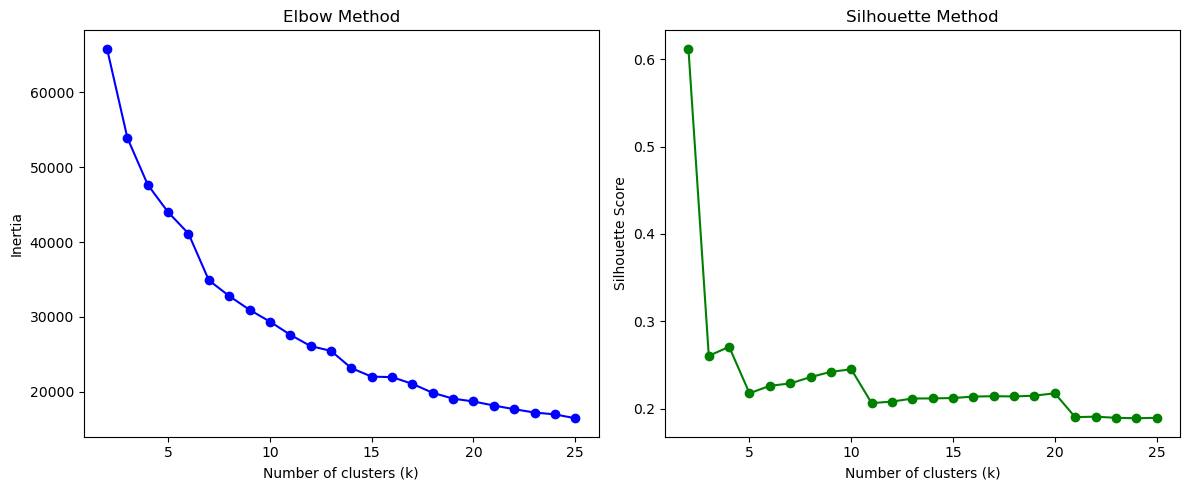

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

inertia = []
silhouette_scores = []
k_values = list(range(2, 25 + 1))

scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_binnary_df)


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()



### Using the elbow-method and with a bit corrolation with the sil-score it looks like the ideal cluster-number is around 4

In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_binnary_df)


non_binnary_df["KMeans_Cluster"] = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit_predict(scaled_data)
sample_for_plot = non_binnary_df.sample(3000, random_state=42)

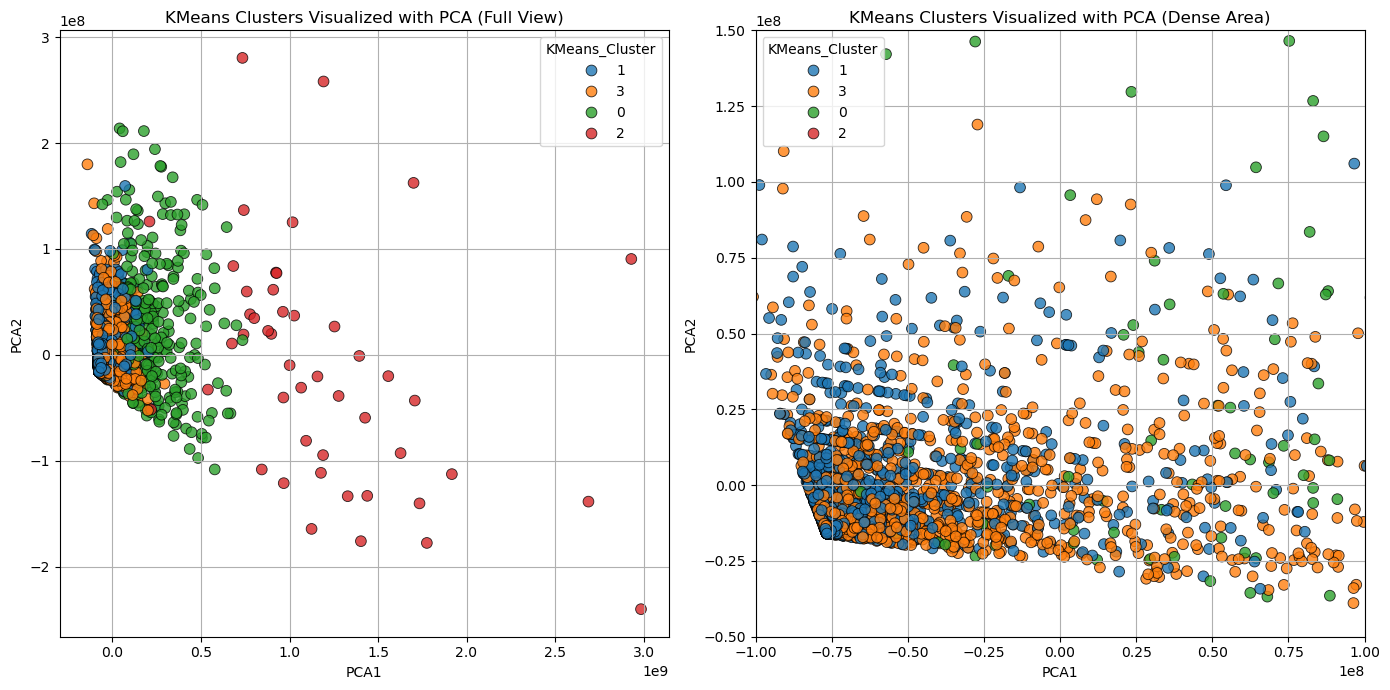

In [44]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(sample_for_plot)

# Create the DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': reduced[:, 0],
    'PCA2': reduced[:, 1],
    'KMeans_Cluster': sample_for_plot['KMeans_Cluster'].astype(str)  # convert to str for color separation
})

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 7)) # Adjust figsize as needed for better layout

# Plot the first scatter plot on the left subplot (axes[0])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[0] # Specify the subplot to draw on
)
axes[0].set_title('KMeans Clusters Visualized with PCA (Full View)')
axes[0].grid(True)
# The legend is often automatically added when using 'hue' with seaborn and matplotlib axes

# Plot the second scatter plot on the right subplot (axes[1])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[1] # Specify the subplot to draw on
)
axes[1].set_title('KMeans Clusters Visualized with PCA (Dense Area)')
axes[1].grid(True)

# Set the limits for the x and y axes for the second subplot to focus on the dense area
axes[1].set_xlim([-1e8, 1e8])
axes[1].set_ylim([-0.5e8, 1.5e8])

plt.tight_layout()

# Show the plot
plt.show()

# 3D

In [45]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

sample_for_plot = non_binnary_df.sample(2000, random_state=42)
pca = PCA(n_components=3)
reduced = pca.fit_transform(sample_for_plot)

plot_df = pd.DataFrame(reduced, columns=['PCA1', 'PCA2', 'PCA3'])
plot_df['KMeans_Cluster'] = sample_for_plot['KMeans_Cluster'].astype(str)  # for categorical coloring


fig = px.scatter_3d(
    plot_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='KMeans_Cluster', # Color points by cluster
    title='KMeans Clusters Visualized in 3D (PCA)',
    labels={'PCA1': 'PCA Component 1', 'PCA2': 'PCA Component 2', 'PCA3': 'PCA Component 3'}, # Optional: set axis labels
    size_max=8 # Adjust point size
)

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40), # Adjust margins
    scene=dict( # Update scene to set axis titles
        xaxis_title='PCA1',
        yaxis_title='PCA2',
        zaxis_title='PCA3'
    )
)
fig.update_layout(scene_camera=dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0), # Center of the view
    eye=dict(x=1.25, y=1.25, z=1.25) # Position of the camera
))
fig.show()

# Lets try it now with 10 clusters:

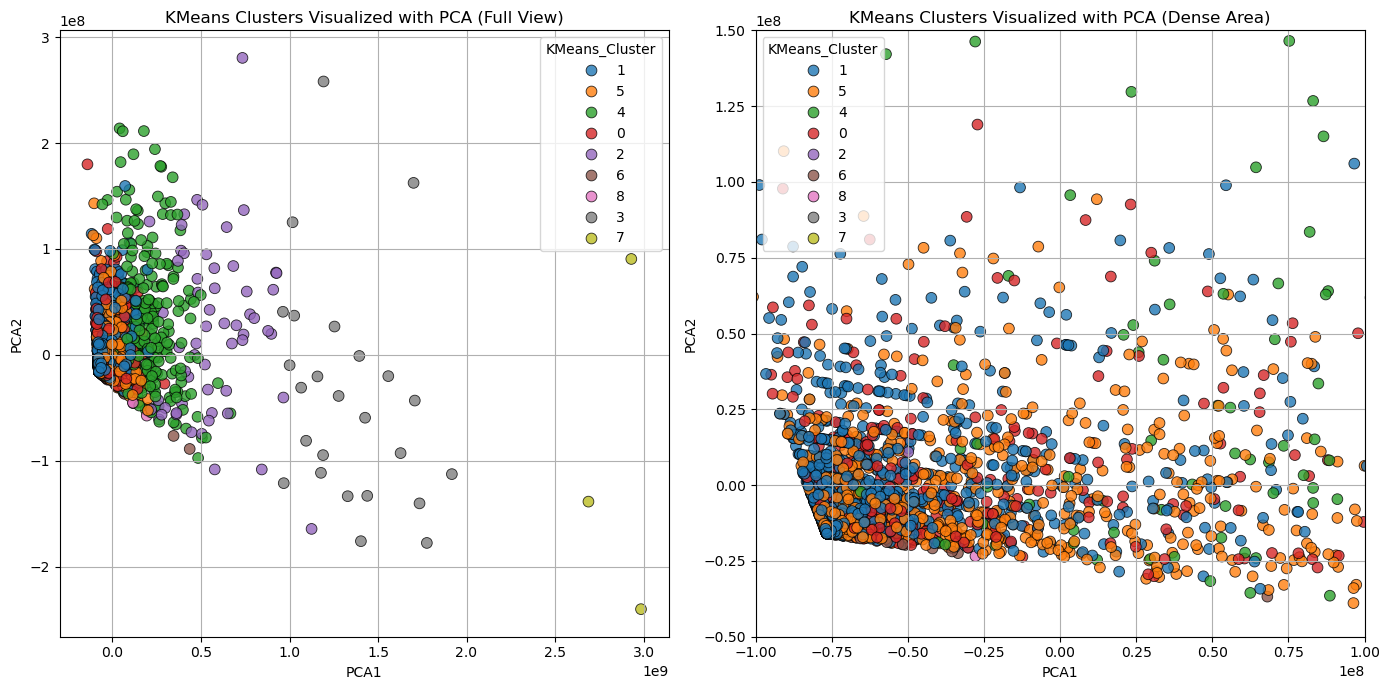

In [46]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_binnary_df)


non_binnary_df["KMeans_Cluster"] = KMeans(n_clusters=10, random_state=42, max_iter=1000).fit_predict(scaled_data)
sample_for_plot = non_binnary_df.sample(3000, random_state=42)

pca = PCA(n_components=2)
reduced = pca.fit_transform(sample_for_plot)

# Create the DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': reduced[:, 0],
    'PCA2': reduced[:, 1],
    'KMeans_Cluster': sample_for_plot['KMeans_Cluster'].astype(str)  # convert to str for color separation
})

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 7)) # Adjust figsize as needed for better layout

# Plot the first scatter plot on the left subplot (axes[0])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[0] # Specify the subplot to draw on
)
axes[0].set_title('KMeans Clusters Visualized with PCA (Full View)')
axes[0].grid(True)
# The legend is often automatically added when using 'hue' with seaborn and matplotlib axes

# Plot the second scatter plot on the right subplot (axes[1])
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k',
    ax=axes[1] # Specify the subplot to draw on
)
axes[1].set_title('KMeans Clusters Visualized with PCA (Dense Area)')
axes[1].grid(True)

# Set the limits for the x and y axes for the second subplot to focus on the dense area
axes[1].set_xlim([-1e8, 1e8])
axes[1].set_ylim([-0.5e8, 1.5e8])

plt.tight_layout()

# Show the plot
plt.show()

In [47]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

sample_for_plot = non_binnary_df.sample(2000, random_state=42)
pca = PCA(n_components=3)
reduced = pca.fit_transform(sample_for_plot)

plot_df = pd.DataFrame(reduced, columns=['PCA1', 'PCA2', 'PCA3'])
plot_df['KMeans_Cluster'] = sample_for_plot['KMeans_Cluster'].astype(str)  # for categorical coloring


fig = px.scatter_3d(
    plot_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='KMeans_Cluster', # Color points by cluster
    title='KMeans Clusters Visualized in 3D (PCA)',
    labels={'PCA1': 'PCA Component 1', 'PCA2': 'PCA Component 2', 'PCA3': 'PCA Component 3'}, # Optional: set axis labels
    size_max=8 # Adjust point size
)

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40), # Adjust margins
    scene=dict( # Update scene to set axis titles
        xaxis_title='PCA1',
        yaxis_title='PCA2',
        zaxis_title='PCA3'
    )
)
fig.update_layout(scene_camera=dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0), # Center of the view
    eye=dict(x=1.25, y=1.25, z=1.25) # Position of the camera
))
fig.show()